In [14]:
import time
import os
import sys
import numpy as np

path = '/Users/austin/Desktop/Projects/autoscript_tem_microscope_client'
sys.path.insert(0, path)

import autoscript_tem_microscope_client
from autoscript_tem_microscope_client import *
from autoscript_tem_microscope_client import TemMicroscopeClient 
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *

import skimage
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree, cKDTree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import defaultdict, deque


import matplotlib.pyplot as plt
%matplotlib ipympl



In [147]:
microscope = TemMicroscopeClient()

# Microscope Computer
microscope._try_connect("10.46.217.241", port = 9095)

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]


### Gun Lens vs Beam Current 

Go to a hole and park the beam there.  We want to see how beam current goes with gun lens

In [55]:
original_gun_lens = microscope.optics.monochromator.focus
print(original_gun_lens)

12.236930737064752


In [56]:
# 0 is at 100 pA

In [145]:
original_gun_lens

12.236930737064752

In [148]:
gun_lens_series = np.linspace(-5, 40, 20)
current_series = []

for val in gun_lens_series:
    # set lens value
    microscope.optics.monochromator.focus = original_gun_lens + val

    # wait
    time.sleep(0.2)

    # measure current
    screen_current = microscope.detectors.screen.measure_current()
    current_series.append(screen_current)

current_series = np.array(current_series) * 1e12

# reset to original
microscope.optics.monochromator.focus = original_gun_lens

Text(0, 0.5, 'Screen Current')

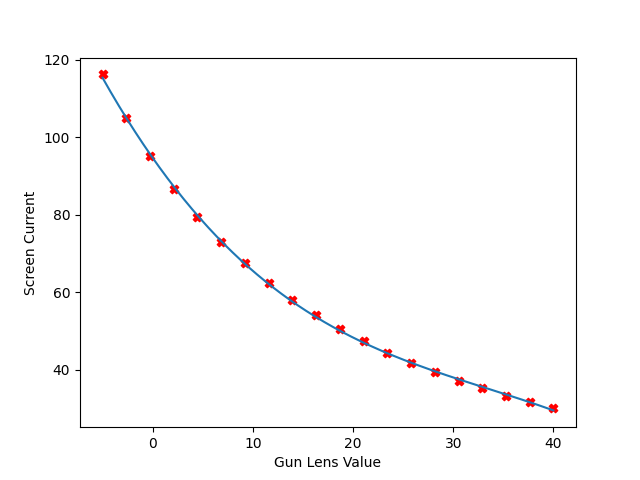

In [149]:
# fit a polynomial:
degree = 3
coeffs = np.polyfit(gun_lens_series, current_series, degree)
poly_func = np.poly1d(coeffs)

# generate fitted values
x_fit = np.linspace(min(gun_lens_series), max(gun_lens_series), 500)
y_fit = poly_func(x_fit)

# plot
plt.figure()
plt.plot(x_fit, y_fit)
plt.scatter(gun_lens_series, current_series, marker='X', c='r')

plt.xlabel('Gun Lens Value')
plt.ylabel('Screen Current')




In [150]:
def current_to_gun(desired_current, poly_func):
    # Define the new polynomial: poly_func(x) - y_target = 0
    adjusted_poly = poly_func - desired_current
    # Find the roots
    x_candidates = adjusted_poly.r
    # Filter for real solutions only (since roots might be complex)
    x_real = x_candidates[np.isreal(x_candidates)].real

    if len(x_real) == 1:
        return(x_real)
    else:
        return(np.max(x_real))

In [156]:
# Example
# we want screen current 100 pA for imaging
desired_current = 100 # pA
gun_val = current_to_gun(desired_current=desired_current, poly_func=poly_func)
microscope.optics.monochromator.focus = float(gun_val)

print(f'Set to: {desired_current} with gun value: {gun_val}')

Set to: 100 with gun value: [-1.39016156]


/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_19136/601711150.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  microscope.optics.monochromator.focus = float(gun_val)


In [157]:
microscope.optics.paused_scan_beam_position = (0,0) # park the beam in the corner

In [61]:
fast_scan = {'pixels': 256, # pixels
            'dwell_time': 1e-6, # sec
            'current':40} # pA

slow_scan = {'pixels': 512, # pixels
            'dwell_time': 5e-6, # sec
            'current':40} # pA

In [62]:
image = microscope.acquisition.acquire_stem_image(scanning_detector = 'HAADF', size = slow_scan['pixels'], dwell_time = slow_scan['dwell_time'])
image = image.data

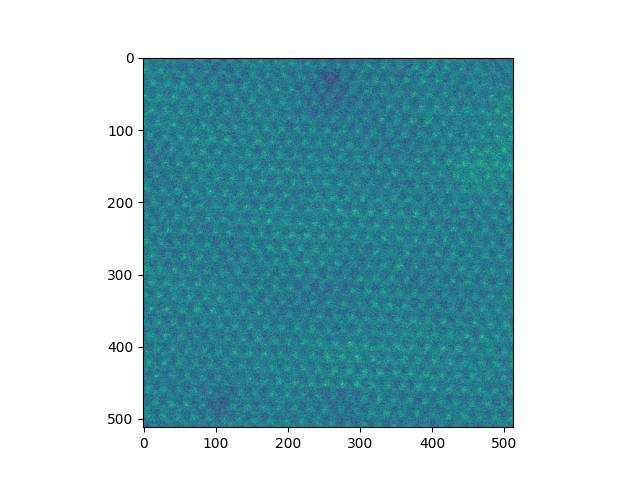

In [63]:
plt.figure()
plt.imshow(image)

## Now, atom-finding with Blob log

In [64]:
# microscope.optics.deflectors.beam_shift for moving the image w/drift (in m)

# microscope.optics.paused_scan_beam_position (from 0 to 1), park the beam, turn up gun lens, unblank then re-blank to blast
# (0,0) (1,0)
# (0,1) (1,1)



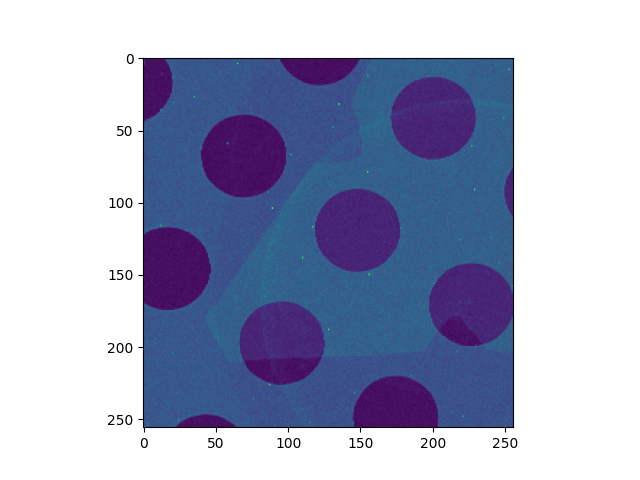

In [41]:
plt.figure()
plt.imshow(image.T)

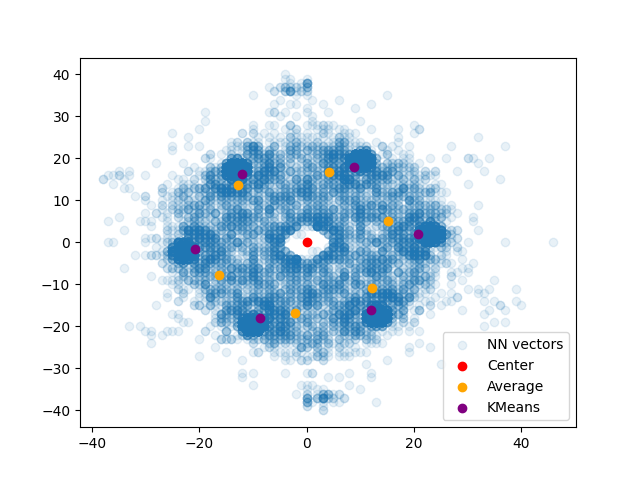

In [67]:
plt.figure()
plt.scatter(nn_vectors[:, :, 0], nn_vectors[:, :, 1], alpha=0.1, label='NN vectors')
plt.scatter(0, 0, c='r', label='Center')
plt.scatter(avg_nn_vectors[:, 0], avg_nn_vectors[:, 1], c='orange', label='Average')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='purple', label='KMeans')
plt.legend()

In [158]:
def graph_filter(blobs, start_node, tolerance, edge_margin):
    # Build KDTree for blobs
    tree = cKDTree(blobs)

    # BFS traversal
    visited = set([start_node])
    queue = deque([start_node])

    while queue:
        current = queue.popleft()
        current_point = blobs[current]

        for offset in cluster_centers:
            expected_pos = current_point + offset
            dist, idx = tree.query(expected_pos)

            if dist <= tolerance and idx not in visited:
                visited.add(idx)
                queue.append(idx)

    # Convert to array for indexing
    visited = np.array(list(visited))

    # Apply edge filtering
    x_min, y_min = blobs.min(axis=0) + edge_margin
    x_max, y_max = blobs.max(axis=0) - edge_margin

    in_bounds = (
        (blobs[visited, 0] > x_min) & (blobs[visited, 0] < x_max) &
        (blobs[visited, 1] > y_min) & (blobs[visited, 1] < y_max)
    )
    final_nodes = visited[in_bounds]

    return blobs[final_nodes]


In [159]:
slow_scan = {'pixels': 512, # pixels
            'dwell_time': 10e-6, # sec
            'current':40} # pA

In [204]:
# take image
image = microscope.acquisition.acquire_stem_image(scanning_detector = 'HAADF', size = slow_scan['pixels'], dwell_time = slow_scan['dwell_time'])
image = np.array(image.data, dtype = 'float64')


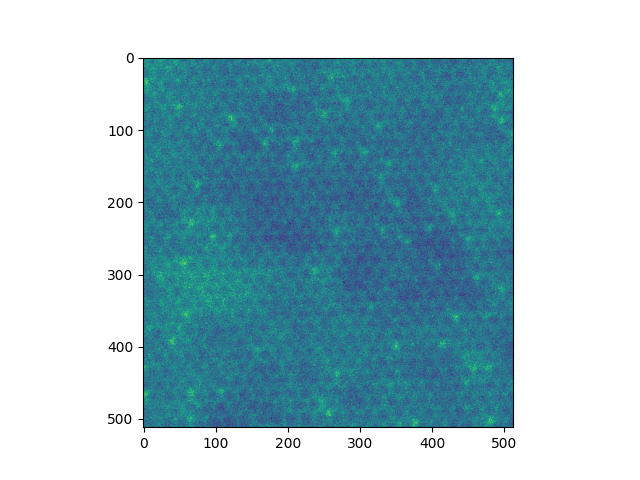

In [205]:
plt.figure()
plt.imshow(image)

In [209]:
## Now we have all the ingredients:

# get blobs
threshold = 0.08 #usally between 0.01 and 0.9  the smaller the more atoms 0.05
atom_size = 10 #in pixels 

blurred =  gaussian_filter(image, sigma=1)
blurred -= blurred.min()
blurred /= blurred.max()
blobs = blob_log(blurred, max_sigma=atom_size, threshold=threshold)
blobs = blobs[:,:2]

init_blobs = blobs.copy()


# filter atoms with kmeans
tree = KDTree(blobs)
distances, indices = tree.query(blobs, k=7)  # k=7 includes self and 6 neighbors
neighbor_ids = indices[:, 1:]  # Exclude self (first neighbor)

nn_vectors = []
for i in range(len(blobs)):
    blob = blobs[i]
    neighbors = blobs[neighbor_ids[i]]  # Get the 6 nearest neighbors
    vectors = neighbors - blob  # Compute vectors to neighbors
    nn_vectors.append(vectors)
nn_vectors = np.array(nn_vectors)  # Shape: (num_atoms, 6, 2)

angles = np.arctan2(nn_vectors[:, :, 1], nn_vectors[:, :, 0])  # Calculate angles for all vectors
sorted_indices = np.argsort(angles, axis=1)  # Indices to sort angles for each atom
nn_vectors_sorted = np.take_along_axis(nn_vectors, sorted_indices[:, :, None], axis=1)
avg_nn_vectors = nn_vectors_sorted.mean(axis=0)

reshaped_nn_vectors = nn_vectors.reshape(-1, 2)  # Shape: (num_atoms * 6, 2)
num_clusters = 6  # Choose the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(reshaped_nn_vectors)
cluster_labels = kmeans.labels_.reshape(nn_vectors.shape[:2])  # Shape: (num_atoms, 6)
cluster_centers = kmeans.cluster_centers_  # Shape: (num_clusters, 2)


# filter with graph theory
start_node = 100
blobs = graph_filter(blobs, start_node = 10, tolerance = 9, edge_margin = 10)


# select every 7th atom
selecte_every = 9

origin = blobs[start_node]
a1 = cluster_centers[0]
a2 = cluster_centers[2]
A = np.column_stack((a1, a2))
relative_positions = blobs - origin
lattice_coords = np.linalg.solve(A, relative_positions.T).T  # shape (N, 2)
lattice_indices = np.round(lattice_coords).astype(int)
mask = (lattice_indices[:,0] % selecte_every == 0) & (lattice_indices[:,1] % selecte_every == 0)
selected_nodes = blobs[mask]

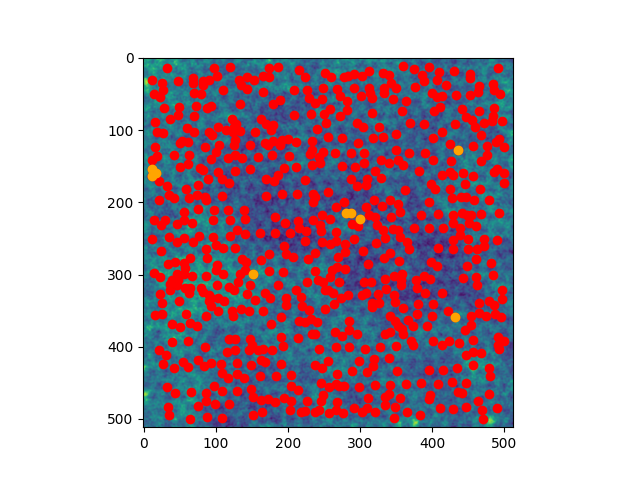

In [210]:
plt.figure()
plt.imshow(blurred)
# plt.scatter(init_blobs[:,1],init_blobs[:,0], c='r')
plt.scatter(blobs[:,1],blobs[:,0], c='r')
plt.scatter(selected_nodes[:,1],selected_nodes[:,0], c='orange')

In [211]:
# define park beam pos in the correct units
beam_positions = selected_nodes / [image.shape[0],image.shape[1]]


# blast it
for pos in beam_positions:
    # change park position
    microscope.optics.paused_scan_beam_position = (pos[0],pos[1])
    # (0,0) (1,0)
    # (0,1) (1,1)

    # increase current
    desired_current = 220 # pA
    gun_val = current_to_gun(desired_current=desired_current, poly_func=poly_func)
    microscope.optics.monochromator.focus = float(gun_val)

    # unblank
    microscope.optics.unblank()

    # put in some wait
    time.sleep(2)

    # blank
    microscope.optics.blank()

    # reduce current
    desired_current = 50 # pA
    gun_val = current_to_gun(desired_current=desired_current, poly_func=poly_func)
    microscope.optics.monochromator.focus = float(gun_val)




/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_19136/1076060528.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  microscope.optics.monochromator.focus = float(gun_val)
/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_19136/1076060528.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  microscope.optics.monochromator.focus = float(gun_val)


In [212]:
# take image
after_image = microscope.acquisition.acquire_stem_image(scanning_detector = 'HAADF', size = slow_scan['pixels'], dwell_time = slow_scan['dwell_time'])
after_image = np.array(image.data, dtype = 'float64')

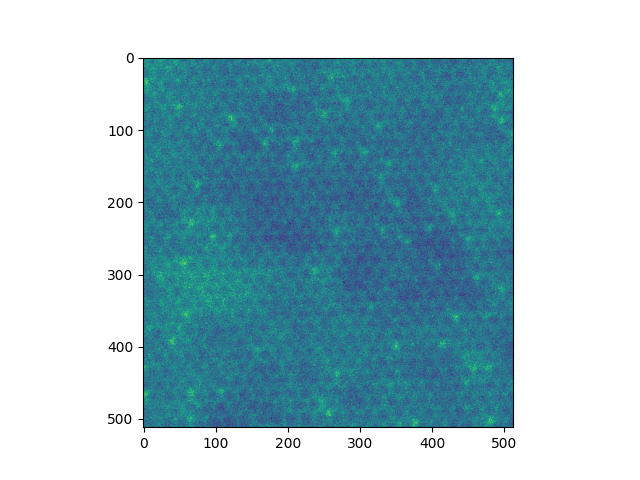

In [213]:
plt.figure()
plt.imshow(after_image)